# PINA: A Python Software for Scientific Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dario-coscia/PINA-tutorial/blob/main/tutorial.ipynb)

<p align="left">
    <img src="imgs/pina_logo.png" alt="PINA Logo" width="90"/>
</p>


Welcome to PINA!

PINA [1] is an open-source Python library providing an intuitive interface for solving differential equations using Physics Informed Neural Networks (PINNs), Neural Operators (NOs) and Reduced Order Models (ROMs). Based on PyTorch and PyTorchLightning, PINA offers a simple and intuitive way to formalize a specific (differential) problem and solve it using neural networks. The approximated solution of a differential equation can be implemented using PINA in a few lines of code thanks to the intuitive and user-friendly interface.

In this workshop, we will guide you through the PINA package, following a step-by-step approach that gradually increases in complexity. Our goal is to demonstrate how PINA can be utilized to solve a wide range of differential problems, starting with basic techniques and progressing to more advanced methods.

We will begin by exploring traditional methods like *Reduced-Order Models (ROM)*. From there, we’ll delve into *Physics-Informed Neural Networks (PINNs)* and their variants, which integrate physical laws into deep learning models to provide more accurate and efficient solutions. As we advance, we’ll introduce *Neural Operators*, a powerful tool for learning mappings between infinite-dimensional spaces, enabling the resolution of even more complex problems.

Throughout the tutorial, we’ll showcase various combinations of these methods to illustrate how they can complement each other. At the core of PINA’s functionality, you’ll learn how to leverage deep learning for scientific machine learning (SciML) tasks, ultimately gaining the ability to solve intricate real-world problems across multiple domains.

By the end of this tutorial, you will have hands-on experience with PINA and a deeper understanding of how to apply it to various differential models and SciML challenges.



## The PINA Workflow 

<p align="center">
    <img src="imgs/pina_wokflow.png" alt="PINA Workflow" width="900"/>
</p>


Let's start with the foundation: the PINA workflow. In PINA, solving a differential problem involves four key steps:

1. **Problem Definition**: The first step is to clearly define the mathematical problem and the physical conditions it must satisfy. PINA provides several specialized classes for this purpose, including `SpatialProblem`, `TimeDependentProblem`, `ParametricProblem`, `InverseProblem`, and the abstract base class `AbstractProblem`. These classes help you structure your problem based on its unique characteristics, whether it involves space, time, parameters, or inverse modeling.

2. **Domain Sampling**: Next, you need to prepare the model's input by discretizing the physical domain or importing data from numerical solvers. This step is crucial for defining the resolution and scope of your model. PINA provides essential tools like the `Conditions` class and the geometry module to facilitate domain sampling and ensure that the input data aligns with the problem's requirements.

3. **Model and Solver Selection**: After setting up the problem and domain, the next step is to build the model. In PINA, models are constructed as PyTorch modules, allowing flexibility and scalability. You also need to choose a solver strategy to optimize the model. PINA implements a variety of solvers and models, which can be used as standalone components, inherited for customization, or created from scratch, offering a range of options depending on your specific needs.

4. **Training**: The final step is optimizing the model using the chosen solver strategy. PINA leverages PyTorch Lightning for this process, providing a robust framework for training. The `Trainer` class, a wrapper around the PyTorch Lightning Trainer, enhances this process with advanced features, enabling more efficient and flexible training strategies.

By following these four steps, PINA streamlines the process of solving differential problems, making it easier to apply deep learning techniques to scientific computing challenges.

We will now begin by solving a simple problem for demonstration purposes. In this example, we will generate a regression dataset and use PINA to implement a Bayesian regressor. Specifically, we will employ Monte Carlo (MC) dropout as a method to approximate Bayesian inference, showcasing how PINA can be used to tackle regression tasks with uncertainty estimation.


## A Simple Regression Problem in PINA

Consider the problem [2] of approximating the following function with a Neural Net model $\mathcal{M}_{\theta}$:
$$y = x^3 + \epsilon, \quad \epsilon\sim\mathcal{N}(0,9),$$
by having only a set of $20$ observations $\{x_i, y_i\}_{i=1}^{20}$, with  $x_i \sim\mathcal{U}[-4, 4]\;\;\forall i\in(1,\dots,20)$.

In PINA to construct this kind of problem we will need to create a class, `BayesianProblem`, inheriting from the `AbstractProblem` class since our problem depends only on input/output data given from an oracle. Later we will see that when learning an Ordinary/Partial Differential Equation *without oracle data* we will need to create a problem by inheriting from different classes. In general, in PINA there are various base classes the user can decide to inherit from, here are some examples (more on the official [documentation](https://mathlab.github.io/PINA/)):
* ``AbstractProblem`` $\rightarrow$ any PINA problem inherits from here, it is usually used when input output data are given
* ``SpatialProblem`` $\rightarrow$ a problem with spatial variable(s) as input for the model (we will see more of this!)
* ``TimeDependentProblem`` $\rightarrow$ a problem with temporal variable(s) as input for the model (see [this tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial3/tutorial.html) if interested)
* ``ParametricProblem`` $\rightarrow$ a problem with parametric variable(s) ``parameter_domain`` as input (see [this tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial1/tutorial.html) if interested)
* ``InverseProblem`` $\rightarrow$ an inverse problem to estimate models' parameters from data (see [this tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial7/tutorial.html) if interested)

The classes `SpatialProblem`, `TimeDependentProblem`, `ParametricProblem` are usually used for learning Ordinary/Partial Differential Equation when we do not have accessible data, as we will see in the PINN section. 

Let's now create the data and the problem class using `AbstractProblem`.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install "pina-mathlab"

from pina import Condition, LabelTensor                                         # importing data structures for problem constrains definition and tensor manipulation
from pina.problem import AbstractProblem                                        # importing the spatial problem class
from pina.geometry import CartesianDomain                                       # importing the geometry module to sample spatial variables easily
import torch                                                                    # import torch for tensor operations


# (a) Data generation and plot
domain = CartesianDomain({'x' : [-4, 4]})                                       # create the geometry domain
x = domain.sample(n=20, mode="random")                                          # sampling 20 random points in [-4, 4]
y = LabelTensor(x.pow(3) + 9*torch.randn_like(x), 'y')                          # obtain target for regression, in PINA the torch.Tensor is labelled

# (b) PINA Problem formulation
class BayesianProblem(AbstractProblem):                                         # here we start creating the problem

    output_variables = ['y']                                                    # define the output variable name, in PINA the tensors can be queried with strings and indeces
    input_variables = ['x']                                                     # define the input variable name, in PINA the tensors can be queried with strings and indeces
    conditions = {'data': Condition(input_points=x, output_points=y)}           # define the conditions, these are the constraints the model will have

/Users/alessio/opt/anaconda3/envs/pina/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We highlight two very important features of PINA

1. Additionally to torch `Tensor` structure, PINA uses the `LabelTensor` structure. This is particularly useful for stacking more tensors together and indexing them using strings
2. The `Condition` object imposes the constraints that the model $\mathcal{M}_{\theta}$ will satisfy.

In [2]:
# EXTRA - on the use of LabelTensor

label_tensor = LabelTensor(torch.rand(3, 4), ['a', 'b', 'c', 'd'])              # We define a 2D tensor, and we index with ['a', 'b', 'c', 'd'] its columns 

print(f'The Label Tensor object, a very short introduction... \n')
print(label_tensor,'\n')
print(f'Torch methods can be used, {label_tensor.shape=}')
print(f'also {label_tensor.requires_grad=} \n')
print(f'But we have labels as well, e.g. {label_tensor.labels=}')
print(f'And we can slice with labels: \n {label_tensor["a"]=}')
print(f'Similarly to: \n {label_tensor[:, 0]=}')

The Label Tensor object, a very short introduction... 

labels(['a', 'b', 'c', 'd'])
LabelTensor([[[0.8276, 0.4066, 0.5046, 0.3089]],
             [[0.9508, 0.7034, 0.2442, 0.1660]],
             [[0.2133, 0.5299, 0.2937, 0.6374]]]) 

Torch methods can be used, label_tensor.shape=torch.Size([3, 4])
also label_tensor.requires_grad=False 

But we have labels as well, e.g. label_tensor.labels=['a', 'b', 'c', 'd']
And we can slice with labels: 
 label_tensor["a"]=LabelTensor([[[0.8276]],
             [[0.9508]],
             [[0.2133]]])
Similarly to: 
 label_tensor[:, 0]=LabelTensor([[[0.8276]],
             [[0.9508]],
             [[0.2133]]])


We will now solve the problem using a simple PyTorch model with Dropout, which we will implement from scratch. It’s worth noting that PINA provides a wide range of state-of-the-art (SOTA) architectures in the `pina.model` module, which you can explore in more detail [here](https://mathlab.github.io/PINA/_rst/_code.html#models). For the solver, we will use a straightforward supervised learning approach by importing the `SupervisedSolver` from `pina.solvers`. This solver is designed to handle typical regression tasks effectively, by minimizing the following loss:
$$
\mathcal{L}_{\rm{problem}} = \frac{1}{N}\sum_{i=1}^N
\mathcal{L}(y_i - \mathcal{M}_{\theta}(x_i))
$$
where $\mathcal{L}$ is a specific loss function, default Mean Square Error:
$$
\mathcal{L}(v) = \| v \|^2_2.
$$
Let's now build the model and solve the problem, we will use the same architecture as in [2].

In [3]:
from pina.solvers import SupervisedSolver                                       # importing the solver for optimizing the model 
from pina.trainer import Trainer                                                # importing the trainer for training the model 

class BayesianModel(torch.nn.Module):                                           # creating the Neural Network Model, visit https://pytorch.org/tutorials/beginner/pytorch_with_examples.html for info
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
                            torch.nn.Linear(1, 100),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(0.5),
                            torch.nn.Linear(100, 1)
                            )
    def forward(self, x):
        return self.layers(x)
    
problem = BayesianProblem()                                                     # setup problem and sample data
model   = BayesianModel()                                                       # setup bayesian model
solver  = SupervisedSolver(problem, model)                                      # setup solver
trainer = Trainer(solver=solver, max_epochs=5000, accelerator='cpu')            # train for 5000 epochs only on cpu (try to change in gpu if your device has it!)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/alessio/opt/anaconda3/envs/pina/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 301   
----------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)
/Users/alessio/opt/anaconda3/envs/pina/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of trainin

Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 225.79it/s, v_num=11, mean_loss=103.0]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 142.79it/s, v_num=11, mean_loss=103.0]


Nice, the model has been trained! Let's now visualize the solutions. Since we used Dropout for training, we have learned a probabilistic bayesian model (see [3] for further details). Thus, every time we will evaluate the forward pass on the input points $x_i$ we will obtain a different results. We can then compute the mean $\mu_\theta$ and the standard deviation $\sigma_\theta$ to understand how accurate the model is and its associated uncertainty.

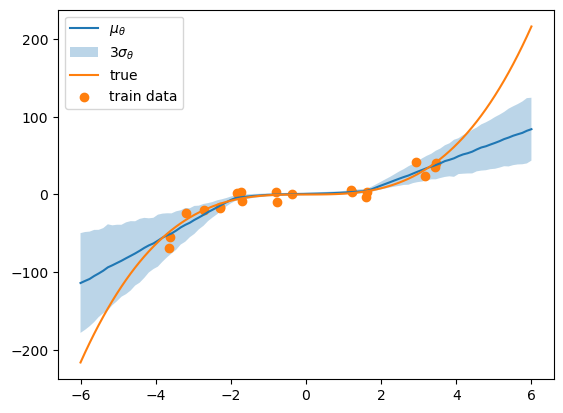

In [4]:
import matplotlib.pyplot as plt                                                 # importing modules for plotting

x_test = LabelTensor(torch.linspace(-6, 6, 100).reshape(-1, 1), 'x')            # getting a grid of data in [-6, 6]
y_test = torch.stack([solver(x_test) for _ in range(1000)], dim=0)              # compute the solution by sampling 1000 NN weights
y_mean, y_std = y_test.mean(0).detach(), y_test.std(0).detach()                 # compute mean and variance of the solution


x_test = x_test.flatten()                                                       # plotting the results
y_mean = y_mean.flatten()
y_std  = y_std.flatten()
plt.plot(x_test, y_mean, label=r'$\mu_{\theta}$')
plt.fill_between(x_test, y_mean-3*y_std, y_mean+3*y_std, alpha=0.3, label=r'3$\sigma_{\theta}$')
plt.plot(x_test, x_test.pow(3), label='true')
plt.scatter(x, y, label='train data')
plt.legend()
plt.show()

## PINA for Reduced Order Modeling
In the last section we used PINA for supervised learning tasks, now we will do a step forward and use PINA for learning a Reduced Order Model. Specifically, our objective will be to learn the solution of a parametric differential equation using a few set of high fidelity data (from simulations), and generalize to new parameters. Our dataset will then be composed of solutions $u$ and parameters of the differential equations $\mu$, and the model we will build is a map from $\mathcal{M}_\theta (\mu) \approx u$.

In particular we are going to use the Proper Orthogonal Decomposition with Radial Basis Function Interpolation(POD-RBF)[4,5]. Here we basically perform a dimensional reduction using the POD approach, and approximating the parametric solution manifold (at the reduced space) using an interpolator (RBF).

We exploit the [Smithers](www.github.com/mathLab/Smithers) library to collect the parametric snapshots. In particular, we use the `NavierStokesDataset` class that contains a set of parametric solutions of the Navier-Stokes equations in a 2D L-shape domain. The parameter is the inflow velocity.
The dataset is composed by 500 snapshots of the velocity (along $x$, $y$, and the magnitude) and pressure fields, and the corresponding parameter values.

To visually check the solutions, let's plot also the data points and the reference solution: this is the expected output of our model.

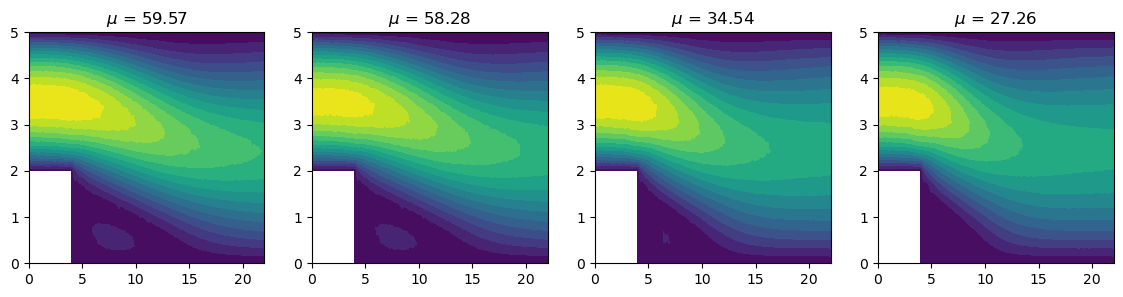

In [5]:
from smithers.dataset import NavierStokesDataset
dataset = NavierStokesDataset()

fig, axs = plt.subplots(1, 4, figsize=(14, 3))
for ax, p, u in zip(axs, dataset.params[:4], dataset.snapshots['mag(v)'][:4]):
    ax.tricontourf(dataset.triang, u, levels=16)
    ax.set_title(f'$\mu$ = {p[0]:.2f}')

The *snapshots* - aka the numerical solutions computed for several parameters - and the corresponding parameters are the only data we need to train the model, in order to predict the solution for any new test parameter.
To properly validate the accuracy, we initially split the 500 snapshots into the training dataset (90% of the original data) and the testing one (the reamining 10%). It must be said that, to plug the snapshots into PINA, we have to cast them to `LabelTensor` objects.

In [6]:
u = torch.tensor(dataset.snapshots['mag(v)']).float()                           # getting the velocity magnitude
p = torch.tensor(dataset.params).float()                                        # getting the parameter

p = LabelTensor(p, labels=['mu'])                                               # transforming in LabelTensors
u = LabelTensor(u, labels=[f's{i}' for i in range(u.shape[1])])

ratio_train_test = 0.9                                                          # split train and test
n = u.shape
n_train = int(u.shape[0] * ratio_train_test)
n_test = u - n_train
u_train, u_test = u[:n_train], u[n_train:]
p_train, p_test = p[:n_train], p[n_train:]

We now procede to build the ROM. We will use the POD (`PODBlock`) and the RBF (`RBFBlock`) objects to build a model (`torch.nn.Module`). Notice that other approaches such as Autoencoder for dimensionality reduction, and Neural Networks for interpolation are possible, and can be combined with the `ReducedOrderModelSolver` (see [here](https://mathlab.github.io/PINA/_rst/solvers/rom.html) the documentation).

In [7]:
from pina.model.layers import PODBlock, RBFBlock                                # importing the POD and RBF layers

class PODRBF(torch.nn.Module):
    def __init__(self, pod_rank, rbf_kernel):
        super().__init__()
        self.pod = PODBlock(pod_rank)
        self.rbf = RBFBlock(kernel=rbf_kernel)
            
    def forward(self, x):                                                       # the forward method find the coefficient of the POD expansion, and then expand the modes to reconstruct the field
        coefficents = self.rbf(x)
        return self.pod.expand(coefficents)

    def fit(self, p, x):                                                        # the fit method is responsible to find POD reduction map, and the RBF interpolation map
        self.pod.fit(x)
        self.rbf.fit(p, self.pod.reduce(x))

It is now time to define the problem, fit the model and show the result! We inherit again from `AbstractProblem`, just defining a simple *input-output* condition. Notice that we will not use a trainer, since there are not parameters to be optimized.

In [8]:
class SnapshotProblem(AbstractProblem):
    output_variables = [f's{i}' for i in range(u.shape[1])]
    parameter_domain = CartesianDomain({'mu': [0, 100]})
    conditions = {
        'io': Condition(input_points=p_train, output_points=u_train)
    }

poisson_problem = SnapshotProblem()                                             # create the problem
pod_rbf = PODRBF(pod_rank=20, rbf_kernel='thin_plate_spline')                   # create the model and fit, try to change the pod_rank and see what happens!
pod_rbf.fit(p_train, u_train)

Very nice! We can now visualize the results,along with the training and test error.

Error summary for POD-RBF model:
  Train: 5.778291e-05
  Test:  5.544038e-05


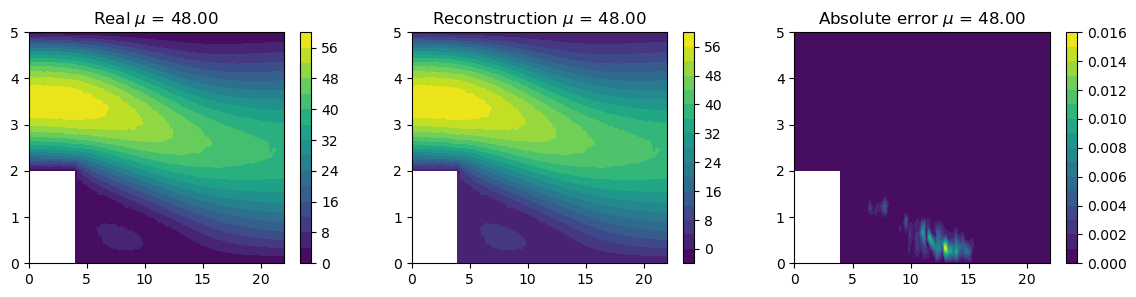

In [9]:
import matplotlib                                                               # for plotting

u_test_rbf = pod_rbf(p_test)                                                    # field reconstruction for train data
u_train_rbf = pod_rbf(p_train)                                                  # field reconstruction for test data

relative_error_train = torch.norm(u_train_rbf - u_train)/torch.norm(u_train)
relative_error_test = torch.norm(u_test_rbf - u_test)/torch.norm(u_test)

print('Error summary for POD-RBF model:')                                       # printing the error
print(f'  Train: {relative_error_train.item():e}')
print(f'  Test:  {relative_error_test.item():e}')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))                                  # visualizing the results
snapshot_number = 10
cm = axs[0].tricontourf(dataset.triang,
                   u_test[snapshot_number].flatten(), levels=16)
axs[0].set_title(f'Real $\mu$ = {float(p[snapshot_number]):.2f}')
plt.colorbar(cm, ax=axs[0])
cm = axs[1].tricontourf(dataset.triang,
                   u_test_rbf[snapshot_number].flatten(),levels=16)
axs[1].set_title(f'Reconstruction $\mu$ = {float(p[snapshot_number]):.2f}')
plt.colorbar(cm, ax=axs[1])
cm = axs[2].tricontourf(dataset.triang,
                   (u_test_rbf[snapshot_number] - u_test[snapshot_number]
                    ).abs().flatten()
                   , levels=16)
axs[2].set_title(f'Absolute error $\mu$ = {float(p[snapshot_number]):.2f}')
plt.colorbar(cm, ax=axs[2])
plt.show()

## PINA for Physics Informed Machine Learning

In the previous section we used PINA for supervised learning, but one of its true strengths lies in physics-informed machine learning. One of the most impactful approaches in this domain is through Physics-Informed Neural Networks (PINNs)[6]. PINNs are deep learning models that seamlessly integrate the laws of physics into the training process. By embedding physical principles—such as differential equations and boundary conditions—directly into the neural network's loss function, PINNs enable the modeling of complex physical systems while ensuring that the predictions remain consistent with established scientific laws. At the end, the PINN methodology can be used to approximate, independently of the discretization, the solution to any differential equation, i.e. $\mathcal{M}_{\theta} \approx u$, with $u$ being the solution of a differential problem.

In particular, we will see how to solve a 2D Poisson problem with Dirichlet boundary conditions, on a hourglass-shaped domain, using different variants of PINNs solvers, namely, standard PINNs [6], Self-Adaptive PINNs (*SAPINNs*) [7] and Residual-Based Attention PINNs (*RBAPINNs*) [8]. Other variants of PINNs are available on PINA, so if you are interested we definitely suggest you to look at PINA solvers on the [documentation](https://mathlab.github.io/PINA/_rst/_code.html#solvers).

As already done, we start by writing the problem class.
We want to solve the following two-dimensional Poisson problem:
\begin{equation}
\begin{cases}
\Delta u(x, y) = \sin{(\pi x)} \sin{(\pi y)} \text{ in } D, \\
u(x, y) = 0 \text{ on } \partial D 
\end{cases}
\end{equation}
where $D$ is a hourglass-shaped domain defined as the difference between a Cartesian domain and two ellipsoids intersecting it, and $\partial D$ is the boundary of the hourglass.

Before writing the problem, we will show you how to build complex domains. One of the greatest features implemented in PINA is the possibility to build custom geometries in a simple and efficient manner. PINA already offeres many built-in domain shapes and Boolean operators to combine them; in alternative, custom locations can be defined from scratch. If you are interested to investigate deeply the `geometry` module of PINA, look at [this Tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial6/tutorial.html).
We will define the hourglass-shaped domain using the already existing classes `CartesianDomain` and `EllipsoidDomain`, exploiting the Boolean classes `Difference` and `Union`.

In [10]:
from pina.geometry import EllipsoidDomain, Difference, CartesianDomain, Union   # importing the geometry class

# (a) Building the interior of the hourglass-shaped domain
cartesian = CartesianDomain({'x': [-3, 3], 'y': [-3, 3]})                       # building a Cartesian domain
ellipsoid_1 = EllipsoidDomain({'x': [-5, -1], 'y': [-3, 3]})                    # building an Ellipse
ellipsoid_2 = EllipsoidDomain({'x': [1, 5], 'y': [-3, 3]})
interior = Difference([cartesian,ellipsoid_1,ellipsoid_2])                      # removing from Cartesian domain the two ellipsis 

# (a) Building the boundary of the hourglass-shaped domain
border_ellipsoid_1 = EllipsoidDomain({'x': [-5, -1], 'y': [-3, 3]},             # sampling the border of the EllipsoidDomain (sample_surface=True activate sampling only on the border)
                                     sample_surface=True)
border_ellipsoid_2 = EllipsoidDomain({'x': [1, 5], 'y': [-3, 3]},
                                     sample_surface=True)
border_1 = CartesianDomain({'x': [-3, 3], 'y': 3})
border_2 = CartesianDomain({'x': [-3, 3], 'y': -3})
ex_1 = CartesianDomain({'x': [-5, -3], 'y': [-3, 3]})
ex_2 = CartesianDomain({'x': [3,5], 'y': [-3, 3]})
border_ells = Union([border_ellipsoid_1,border_ellipsoid_2])
border = Union([
                border_1,
                border_2,
                Difference([
                            Union([border_ellipsoid_1,border_ellipsoid_2]),
                            ex_1,
                            ex_2
                            ])
                ])

# (c) Sample the domains
interior_samples = interior.sample(n=1000, mode='random')                       # Once the domains are built we can sample inside the domains
border_samples = border.sample(n=1000, mode='random')

Nice! Now that we have built the domain, let's try to plot them

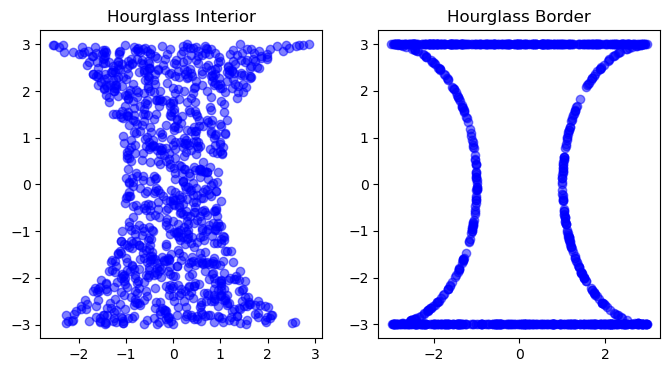

In [11]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(interior_samples.extract('x'),
            interior_samples.extract('y'),
            c='blue', alpha=0.5)
plt.title("Hourglass Interior")
plt.subplot(1, 2, 2)
plt.scatter(border_samples.extract('x'),
            border_samples.extract('y'),
            c='blue', alpha=0.5)
plt.title("Hourglass Border")
plt.show()

Very good! We will know implement the problem class. Differently from the previous examples in which we used `AbstractProblem` as super class, to build the Poisson problem we will inherit from `SpatialProblem`.
This is because we will build a model whose inputs are spatial variable(s).

In [12]:
from pina.problem import SpatialProblem                                         # importing the SpatialProblem class
from pina.operators import laplacian                                            # importing PINA differential operators, already available 
from pina.equation import FixedValue, Equation                                  # importing Dirichlet conditions and a standard Equation wrapper

def poisson_equation(input_, output_):                                          # here we build a simple function that returns the residual od the poisson equation, i.e. residual = Δu - sin(πx)sin(πy)
    force_term = (torch.sin(input_.extract(['x'])*torch.pi) *
                    torch.sin(input_.extract(['y'])*torch.pi))
    laplacian_u = laplacian(output_, input_, components=['u'], d=['x', 'y'])
    return laplacian_u - force_term

class Poisson(SpatialProblem):                                                  
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1], 'y': [0, 1]})    
    conditions = {
        'border':   Condition(location=border,                                  # notice here we pass location and equation at the conditions. This means that we want the network to respect the equation at those locations.
                              equation=FixedValue(0.)),
        'interior': Condition(location=interior,
                              equation=Equation(poisson_equation)),
    }

poisson_problem = Poisson()                                                     # creating the problem

As you can see, writing the problem class for a differential equation is still very easy! The main difference is the inheritance, and the fact that we use `location` and `equation` inside `Condition`. We will not go deeply inside the `Equation` class, but this object can be very useful for creating modular problem classes (see [this Tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial12/tutorial.html) if interested).

Once the problem is set, we need to sample the domain to obtain the data. Don't worry, if you forget to sample an error will be raised before training 😉

In [13]:
print('Points are not automatically sampled, you can see this by:')
print(f'    {poisson_problem.have_sampled_points=}\n')
print('But you can easily sample by running .discretise_domain:')
poisson_problem.discretise_domain(n=1000, locations=['interior'])               # here we sample 1000 points in the interior
poisson_problem.discretise_domain(n=100, locations=['border'])                  # here we sample 1000 points on the border
print(f'    {poisson_problem.have_sampled_points=}')

Points are not automatically sampled, you can see this by:
    poisson_problem.have_sampled_points=False

But you can easily sample by running .discretise_domain:
    poisson_problem.have_sampled_points=True


After we have set the problem, and sampled the domain we need to build a model $\mathcal{M}_{\theta}$. For this, we will now use the custom PINA models available [here](https://mathlab.github.io/PINA/_rst/_code.html#models).
We will use a feed-forward Neural Network by importing the class `FeedForward`. This Neural Network takes as input the coordinates (in this case $x$ and $y$) and provides the unkwown field of the Poisson problem. In this tutorial, the neural network is composed by two hidden layers of $10$ neurons each with `Tanh` activation

In [14]:
from pina.model import FeedForward                                              # importing the FeedForward model


model = FeedForward(
    func = torch.nn.Tanh,
    layers=[10]*2,
    output_dimensions=len(poisson_problem.output_variables),                    # the output dimension is the field dimension
    input_dimensions=len(poisson_problem.input_variables)                       # the input dimension is the coordinates dimension
)

The last part of the PINA pipeline requires a `Solver` and a `Trainer`. As we said before, we will use the classical `PINN` solver and its variants, namely `SAPINN` and `RBAPINN`. We brifely report below how their loss function is defined:

**Classical PINN**
$$\theta_{\rm{best}}=\min_{\theta}\mathcal{L}_{\rm{problem}}(\theta), \quad  \mathcal{L}_{\rm{problem}}(\theta)= \frac{1}{N_{D}}\sum_{i=1}^N
\mathcal{L}(\Delta\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i) - \sin(\pi x_i)\sin(\pi y_i)) +
\frac{1}{N}\sum_{i=1}^N
\mathcal{L}(\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i))$$

**SAPINN**
$$\theta_{\rm{best}}=\min_{\theta}\max_{\lambda_{\Omega}, \lambda_{\partial \Omega}}\mathcal{L}_{\rm{problem}}(\theta), \quad  \mathcal{L}_{\rm{problem}}(\theta)= \frac{1}{N_{D}}\sum_{i=1}^N
m(\lambda_{\Omega}^i)\mathcal{L}(\Delta\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i) - \sin(\pi x_i)\sin(\pi y_i)) +
\frac{1}{N}\sum_{i=1}^N
m(\lambda_{\partial \Omega}^i)\mathcal{L}(\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i))$$

**RBAPINN**
$$\theta_{\rm{best}}=\min_{\theta}\mathcal{L}_{\rm{problem}}(\theta), \quad  \mathcal{L}_{\rm{problem}}(\theta)= \frac{1}{N_{D}}\sum_{i=1}^N
\lambda_{\Omega}^i\mathcal{L}(\Delta\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i) - \sin(\pi x_i)\sin(\pi y_i)) +
\frac{1}{N}\sum_{i=1}^N
\lambda_{\partial \Omega}^i\mathcal{L}(\mathcal{M}_{\theta}(\mathbf{x}_i, \mathbf{y}_i)), \quad \lambda^i_{k+1} \leftarrow \gamma\lambda^i_{k} + 
        \eta\frac{\lvert r_i\rvert}{\max_j \lvert r_j\rvert}\;\forall k,i$$

We will train for $1000$ epochs with default optimizers parameters. These parameters can be modified as desired, have a look at the solvers documentation [here](https://mathlab.github.io/PINA/_rst/_code.html#solvers). We use the `MetricTracker` class to track the metrics during training. We will not go into details of the many features the `Trainer` class has, but in [this Tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial11/tutorial.html) we cover the most important ones to boost model performance.

In [15]:
from pina.solvers import PINN, SAPINN, RBAPINN                                  # importing the solvers
from pina.callbacks import MetricTracker                                        # importing the MetricTracker to track the loss during training


trainers = {}                                                                   # create a dictionary of trainers, it will be used later for plotting
for Solver in [PINN, SAPINN, RBAPINN]:                                          # iterate over solvers
    print('Training with {Solver.__name__} solver')
    solver = Solver(poisson_problem, model)
    trainer = Trainer(solver,                                                   # we train on CPU for 1000 epochs and avoid model summary at beginning of training (optional)
                      max_epochs=2000,
                      callbacks=[MetricTracker()],
                      accelerator='cpu',
                      enable_model_summary=False)
    trainer.train()
    trainers[Solver.__name__] = trainer                                         # saving trainer
    model.apply(                                                                # reset the model parameters
        lambda layer: layer.reset_parameters()
        if hasattr(layer, 'reset_parameters') else None
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alessio/opt/anaconda3/envs/pina/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training with {Solver.__name__} solver
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 117.43it/s, v_num=12, border_loss=0.00199, interior_loss=0.0271, mean_loss=0.0145]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 84.27it/s, v_num=12, border_loss=0.00199, interior_loss=0.0271, mean_loss=0.0145] 
Training with {Solver.__name__} solver


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 74.03it/s, v_num=13, border_loss=0.00243, interior_loss=0.0297, mean_loss=0.0161]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 58.07it/s, v_num=13, border_loss=0.00243, interior_loss=0.0297, mean_loss=0.0161]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training with {Solver.__name__} solver
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 116.20it/s, v_num=14, border_loss=0.0015, interior_loss=0.00857, mean_loss=0.00504] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 84.49it/s, v_num=14, border_loss=0.0015, interior_loss=0.00857, mean_loss=0.00504] 


Very nice! Let's see how the mean losses changed during training. For this, we will use the `Plotter` class.

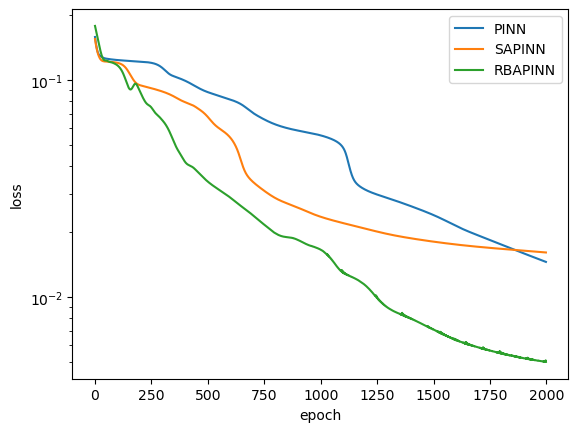

In [16]:
from pina import Plotter                                                        # importing the plotter class

plotter = Plotter()
for solver_name, trainer in trainers.items():                                   # iterate over the saved trainers
    plotter.plot_loss(trainer, logy=True, label=solver_name)

As we can see the `RBAPINN` solver is the one better performing overall, i.e. achieving the lowest mean square error.

## PINA for Autoregressive Neural Operators

In the previous section, we explored the application of PINA in supervised learning and PINNs, but another fundamental advancement in scientific machine learning is through neural operators. Neural operators (NO) extend the capabilities of traditional neural networks by learning mappings between function spaces, i.e. operators, which makes them particularly suited for complex physical systems governed by partial differential equations (PDEs). For example, a NO could map the field at the initial temporal condition of a PDE, to the evolution at a specific time step; or the parameter of a differential equation to its solution for the specific parameter. Instead of operating on discrete inputs, neural operators approximate solutions in a continuous manner, making them independent of specific discretizations.

In particular in this tutorial we will focus on Autoregressive Neural Operator [11]. We will focus on PDEs in one time dimension $t\in[0,T]$, and (possibly) multiple spatial dimensions $\mathbf{x}\in\Omega\subset\mathbb{R}^d$. We hone in on solving PDEs of the form:
$$
\begin{split}
    &\partial_t u(\mathbf{x},t) = F(\mathbf{x}, t, u,\partial_{\mathbf{x}}u,\dots) \quad\quad\quad (\mathbf{x},t)\in\Omega\times[0,T]\\
    &u(\mathbf{x}, t=0)=u^0(\mathbf{x}), \quad B[u](t, \mathbf{x}), \;\;\,\quad \mathbf{x}\in\Omega, \;(\mathbf{x},t)\in\partial\Omega\times[0,T] 
\end{split}
$$
where $u:\Omega\times[0,T] \rightarrow \mathbb{R}^n$ is the solution, with $u^0$ initial condition at $t=0$ and boundary condition $B[u]$ (e.g. Dirichlet) on the boundary $\partial\Omega$ of the domain. The Autoregressive Neural Operator is a model $\mathcal{M}_\theta$ that maps the solution at time $t$ to the one at time $t+\delta$:
$$
u_{t+\delta} \approx \mathcal{M}_\theta(u_t), \quad \delta>0.
$$


We will focus on solving the **Kuramoto-Sivashinsky** equation:

\begin{equation*}
\begin{cases}
\partial_t u + \partial_{xxxx} u + \partial_{xx} u + u \partial_x u = 0 \quad\quad\quad x \in [-\frac{L}{2},\frac{L}{2}], \quad t \in [0,T] \\
u(-\frac{L}{2},t) = u (\frac{L}{2},t) \quad\quad\quad t \in [0,T]\\
u(x,0) = f(x,0)
\end{cases}
\end{equation*}

where $f$ is a sum of long-wavelength sinusoidal function. 

Training and test data have been generated exploiting the methodology described in [12].

In [17]:
from utils import Dataset                                                       # this is not PINA! we built a preprocessing class for dataset management 

# get the data
data_train = Dataset('data/KS_train.h5')
data_test = Dataset('data/KS_test.h5')

# define the problem
class NOProblem(AbstractProblem):
    input_variables = ['u']
    output_variables = ['u']
    conditions = {'data' : Condition(input_points=data_train.pde,
                                    output_points=data_train.pde)}
no_problem = NOProblem()

Creating the solver

We are now going to construct the Autoregressive Solver, following [11]. 
We need to define 1) the loss function used to train the solver 2) the unrolling procedure for predicting over the test data:

1) for each batch, at each epoch, a random interval $[t,t+\delta]$ is selected (in our solver, $\delta=1$) and the difference $du_{\delta}(x,t) = u(x,t+\delta)-u(x,t)$ is computed; the neural network computes an approximation of $du_{\delta}$ taking $u$ in input, i.e. $\overline{du}_{\delta}(x,t) = \mathcal{M}_{\theta} (u(x,t))$; eventually, the MSE loss between $du$ and $\overline{du}_{\delta}(x,t)$ is computed;
2) during inference phase, $\overline{du}_{\delta}(x,t)$ is computed for each timestep $t$ in the specified unrolling interval. In our data, the timestep discretization is equal to $dt=0.1$ sec.




In [18]:
class AutoregressiveSolver(SupervisedSolver):
    
    @torch.no_grad()
    def unroll(self, input, unrollings=100):
        """
        Unrolling the prediction from the initial input for unrollings steps.
        """
        trajectory = [input]
        for _ in range(unrollings):
            du_hat_t = self.neural_net.torchmodel(trajectory[-1])
            trajectory.append(trajectory[-1] + du_hat_t)
        return torch.stack(trajectory, 1)
    
    def loss_data(self, input_pts, output_pts):
        """
        Computing the variational loss for an autoregressive solver. The 
        output have shape [B, Nt, Nx, D], input_pts are not used but kept for
        consistency.
        """
        # Extract a time interval
        t_start = torch.randint(0,                                              # sampling random starting time
                                output_pts.shape[1]-1,
                                (output_pts.shape[0],),
                                device=input_pts.device)
        t_end = t_start + 1 
        idx_batch = torch.arange(output_pts.shape[0])
        u_start = output_pts[idx_batch, t_start, ...]
        u_final = output_pts[idx_batch, t_end, ...]
        du = u_final - u_start
        # Forward pass
        du_hat = self.forward(u_start)
        # Compute loss
        mse_loss = (du_hat - du).pow(2).mean().as_subclass(torch.Tensor)
        return mse_loss

The NO we use here is the **Fourier Neural Operator** (FNO) [9], already implemented in PINA.

In [19]:
from pina.model import FNO

lifting_net = torch.nn.Linear(1, 64)
projecting_net = torch.nn.Linear(64, 1)
model = FNO(lifting_net=lifting_net,
            projecting_net=projecting_net,
            n_modes=32,
            n_layers=5,
            dimensions=1,
            inner_size=64,
            func=torch.nn.SiLU,
            padding=8)

trainer = Trainer(solver=AutoregressiveSolver(no_problem, model=model), max_epochs=200, batch_size=64, accelerator='cpu')
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alessio/opt/anaconda3/envs/pina/lib/python3.10/site-packages/torch/_tensor.py:1279: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  ret = func(*args, **kwargs)

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 676 K 
----------------------------------------
676 K     Trainable params
0         Non-trainable params
676 K     Total params

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 

/Users/alessio/opt/anaconda3/envs/pina/lib/python3.10/site-packages/pina/model/fno.py:162: UserWarning: LabelTensor passed as input is not allowed, casting LabelTensor to Torch.Tensor
  warnings.warn(
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 199: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s, v_num=15, mean_loss=2.57e-5]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s, v_num=15, mean_loss=2.57e-5]


After the training phase, we obtain the prediction to compare with the test data unrolling the model starting from the initial data `data_test.pde[:, 0, ...]` all over the time interval:

In [20]:
sol = trainer.model.unroll(input=data_test.pde[:, 0, ...],unrollings=int(data_test.pde.shape[1]-1))

Let's visualize the predictions and compare them with the test data: 

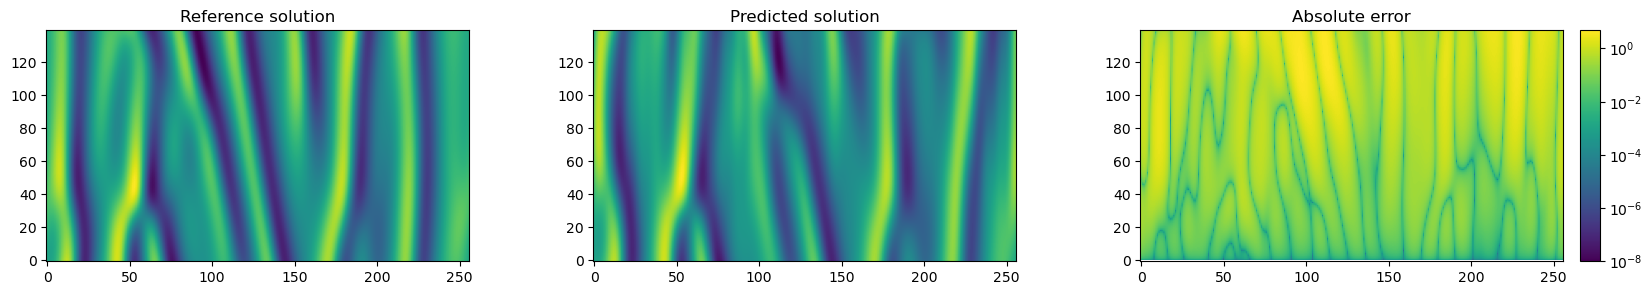

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
idx = 1
fig, axs = plt.subplots(1, 3, figsize=(20, 3)) 
axs[0] = plt.subplot(1, 3, 1,)
axs[0].imshow(data_test.pde[idx].squeeze(-1), origin='lower')
axs[0].set_title('Reference solution')
axs[1] = plt.subplot(1, 3, 2)
axs[1].imshow(sol[idx].squeeze(-1), origin='lower')
axs[1].set_title('Predicted solution')
axs[2] = plt.subplot(1, 3, 3)
diff = (data_test.pde[idx]-sol[idx]).abs().squeeze(-1)
cm = axs[2].imshow(diff, origin='lower', norm=colors.LogNorm(vmin=diff.min().item()+1e-8, vmax=diff.max().item()),cmap='viridis')
axs[2].set_title('Absolute error')
cax = fig.add_axes([0.9, 0.11, 0.01, 0.77])
fig.colorbar(cm, cax = cax, ax=axs[2])


The results are not bad, taking in account the complex nature of the Kuramoto-Sivashinsky equation, which usually requires hours of training to get accurate predictions.

## GitHub Repo

You can download this tutorial scanning *the QR code below*:

<p align="center">
    <img src="imgs/qr-code.png" alt="QR CODE" width=300"/>
</p>


### References

[1] *Coscia, Dario, et al. "Physics-informed neural networks for advanced modeling." Journal of Open Source Software, 2023.*

[2] *Hernández-Lobato, José Miguel, and Ryan Adams. "Probabilistic backpropagation for scalable learning of bayesian neural networks." International conference on machine learning, 2015.*

[3] *Gal, Yarin, and Zoubin Ghahramani. "Dropout as a bayesian approximation: Representing model uncertainty in deep learning." International conference on machine learning, 2016.*

[4] *Rozza, Gianluigi, Giovanni Stabile, and Francesco Ballarin, eds. Advanced reduced order methods and applications in computational fluid dynamics. Society for Industrial and Applied Mathematics, 2022.*

[5] *Hesthaven, Jan S., and Stefano Ubbiali. "Non-intrusive reduced order modeling of nonlinear problems using neural networks." Journal of Computational Physics, 2018*

[6] *Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational Physics, 2019.*

[7] *McClenny, Levi D., and Ulisses M. Braga-Neto. "Self-adaptive physics-informed neural networks." Journal of Computational Physics, 2023.*

[8] *Anagnostopoulos, Sokratis J., et al. "Residual-based attention in physics-informed neural networks." Computer Methods in Applied Mechanics and Engineering, 2024.*

[9] *Li, Zongyi, et al. "Fourier Neural Operator for Parametric Partial Differential Equations." International Conference on Learning Representations, 2021.*

[10] *Brandstetter, J., Worrall, D. E., & Welling, M. Message Passing Neural PDE Solvers. In International Conference on Learning Representations.*

[11] *McCabe, M., Harrington, P., Subramanian, S., & Brown, J. Towards Stability of Autoregressive Neural Operators. Transactions on Machine Learning Research.* 

[12] *Bar-Sinai, Y., Hoyer, S., Hickey, J., & Brenner, M. P. (2019). Learning data-driven discretizations for partial differential equations. Proceedings of the National Academy of Sciences, 116(31), 15344-15349.*

### Licese and Acknowledgement

This tutorial is done with the help of the PINA contributors, which we acknowledge for their constant help in the develop and maintenance process of the software. We distribute this tutorial under the MIT License available [here](https://github.com/mathLab/PINA/blob/master/LICENSE.rst).